In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import math
import warnings

# Suppress specific UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
def load_mnist_dataset(root: str = "data", train: bool = True, download: bool = True) -> datasets.MNIST:
    """
    Load the MNIST dataset.

    Args:
        root (str): Root directory of the dataset.
        train (bool): If True, loads the training dataset; otherwise, loads the test dataset.
        download (bool): If True, downloads the dataset if it is not already available.

    Returns:
        torchvision.datasets.MNIST: The MNIST dataset.
    """
    return datasets.MNIST(
        root=root,
        train=train,
        transform=transforms.ToTensor(),
        download=download,
    )

train_data = load_mnist_dataset(train=True)
test_data = load_mnist_dataset(train=False)

In [4]:
print(f"Size of the test data is {test_data.data.shape}")
print(f"Size of the train data is {train_data.data.shape}")

Size of the test data is torch.Size([10000, 28, 28])
Size of the train data is torch.Size([60000, 28, 28])


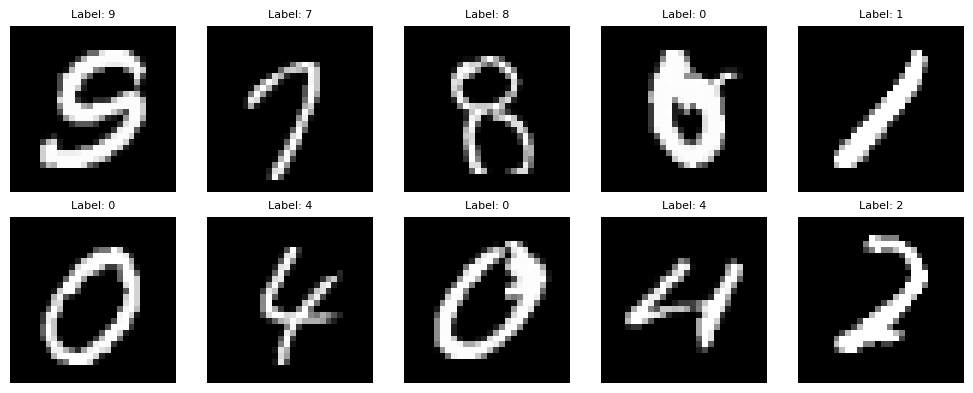

In [5]:
def visualize_random_images(
    dataset: datasets.MNIST, num_images: int = 10, images_per_row: int = 5
) -> None:
    """
    Displays a set of random images from the dataset in a grid format.

    Parameters:
    dataset (torch.utils.data.Dataset): The dataset to sample images from.
    num_images (int): The total number of images to display (default: 10).
    images_per_row (int): Number of images per row in the grid (default: 5).

    Returns:
    None
    """
    if num_images <= 0 or images_per_row <= 0:
        raise ValueError("num_images and images_per_row must be positive integers.")

    dataset_size = len(dataset)
    if num_images > dataset_size:
        raise ValueError(f"num_images ({num_images}) cannot be greater than dataset size ({dataset_size}).")

    random_idx = np.random.choice(dataset_size, num_images, replace=False)

    # Calculate the needed number of rows
    num_rows = math.ceil(num_images / images_per_row)

    fig, axes = plt.subplots(
        num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2)
    )

    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, idx in enumerate(random_idx):
        data, target = dataset[idx]
        image = data.squeeze().numpy()  # Convert tensor to numpy format

        # Display image
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(f"Label: {target}", fontsize=8)
        axes[i].axis("off")

    # Hide any unused subplot areas
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()


visualize_random_images(train_data, num_images=10, images_per_row=5)

In [6]:
loaders = {
    "train": DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    "test": DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1),
}

print(loaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7745fe9b02f0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7745fbe9d590>}


In [7]:
class CNN(nn.Module):
    """
    A Convolutional Neural Network (CNN) for image classification on the MNIST dataset.
    """

    def __init__(self):
        super(CNN, self).__init__()

        # Conv layer 1: 1 input channel → 10 output channels
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)

        # Conv layer 2: 10 input channels → 20 output channels
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        # Dropout layer to reduce overfitting
        self.conv2_drop = nn.Dropout2d()

        # Fully connected layer: 320 input → 50 output neurons
        self.fc1 = nn.Linear(320, 50)

        # Fully connected layer: 50 input → 10 output (10 classes)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the CNN.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 10).
        """
        # Conv1 → ReLU → Max Pooling
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # Conv2 → Dropout → ReLU → Max Pooling
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # Flatten feature maps into a 1D vector
        x = x.view(-1, 320)

        # Fully Connected Layer 1 + ReLU
        x = F.relu(self.fc1(x))

        # Dropout applied before final layer
        x = F.dropout(x, training=self.training)

        # Fully Connected Layer 2 (final output layer)
        x = self.fc2(x)

        return F.softmax(x, dim=1)

| **Layer**                          | **Operation**     | **Shape Transformation** (for MNIST: `(1, 28, 28)`) |
|-------------------------------------|------------------|-----------------------------------------------|
| **Conv2D (1 → 10, 5×5 kernel)**     | Convolution      | `(1, 28, 28) → (10, 24, 24)`                 |
| **Max Pooling (2×2)**               | Downsampling     | `(10, 24, 24) → (10, 12, 12)`                |
| **Conv2D (10 → 20, 5×5 kernel)**    | Convolution      | `(10, 12, 12) → (20, 8, 8)`                  |
| **Dropout**                         | Regularization   | No shape change                              |
| **Max Pooling (2×2)**               | Downsampling     | `(20, 8, 8) → (20, 4, 4)`                    |
| **Flatten**                         | Reshape          | `(20, 4, 4) → (320,)`                        |
| **Fully Connected (320 → 50)**      | Dense Layer      | `(320,) → (50,)`                             |
| **Dropout**                         | Regularization   | No shape change                              |
| **Fully Connected (50 → 10)**       | Output Layer     | `(50,) → (10,)`                              |

### 1. First Convolutional Layer
The first convolutional layer applies 10 convolutional filters, each of size $5 \times 5$, to the input image. Given that the input consists of a single grayscale image of dimensions $28 \times 28$, each of the 10 filters generates a separate feature map. Since no padding is applied, the spatial dimensions of the output feature maps are reduced as follows:  

$$
28 \times 28 \rightarrow 24 \times 24
$$

At this stage, the convolutional layer primarily captures low-level features such as edges and corners.



### 2. First Max Pooling Layer
A max pooling operation is performed with a $2 \times 2$ filter, selecting the maximum value from each $2 \times 2$ region. This results in a downsampling effect, reducing the spatial dimensions by half:

$$
24 \times 24 \rightarrow 12 \times 12
$$

The purpose of max pooling is threefold:
- Reduction of computational complexity by decreasing the number of activations.
- Extraction of dominant features, ensuring the most relevant spatial information is retained.
- Mitigation of overfitting by enforcing translational invariance.



### 3. Second Convolutional Layer
The second convolutional layer applies 20 convolutional filters of size $5 \times 5$ to the previous feature maps. Since there were 10 feature maps from the first layer, this layer now operates on these learned representations, capturing more complex hierarchical features such as textures and specific shapes. As in the first convolutional layer, the lack of padding results in a reduction of spatial dimensions:

$$
12 \times 12 \rightarrow 8 \times 8
$$



### 4. Dropout Regularization
A dropout layer is applied to randomly disable a subset of neurons during training, thus preventing overfitting. While dropout has no effect on the shape of the feature maps, it improves generalization by reducing dependency on specific neurons and encouraging the network to learn more robust features.



### 5. Second Max Pooling Layer
Similar to the first max pooling layer, the second $2 \times 2$ max pooling operation is applied to the feature maps, further reducing the spatial dimensions:

$$
8 \times 8 \rightarrow 4 \times 4
$$




### 6. Flattening Operation
Before passing the learned representations to fully connected layers, the feature maps are flattened into a one-dimensional vector. Given that there are 20 feature maps of size $4 \times 4$, the resulting vector has the following shape:

$$
(20, 4, 4) \rightarrow (320,)
$$



### 7. First Fully Connected Layer
A fully connected layer applies a linear transformation to the flattened vector, mapping it to a feature representation of dimension $50$:

$$
(320,) \rightarrow (50,)
$$




### 8. Dropout Regularization
A second dropout layer is introduced to further enhance generalization and prevent overfitting. Again, this does not affect the shape of the data but improves robustness.



### 9. Output Layer and Classification
The final layer of the network is a fully connected layer that outputs 10 values, each corresponding to a digit class (0-9):

$$
(50,) \rightarrow (10,)
$$

These 10 values represent the raw logits, which are subsequently passed through a softmax activation function to produce class probabilities.



## Softmax Activation Function
The softmax function is applied to the output layer to convert the raw scores ($z_i$) into probabilities ($p_i$), ensuring that they sum to 1. The softmax function is defined as:

$$
p_i = \frac{e^{z_i}}{\sum_{j=1}^{10} e^{z_j}}
$$

where:
- $ z_i $ represents the raw output (logit) for class $ i $,
- $ e^{z_i} $ exponentiates each logit, ensuring non-negative values,
- The denominator normalizes the values so they sum to 1.

This transformation ensures that the network’s final output can be interpreted as a probability distribution over the 10 digit classes. The predicted class is determined by selecting the index with the highest probability.

# Training The Model

We check whether `cuda` is available. If not, we will move the model to `cpu`

In [11]:
import torch

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, optimizer, and loss function
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Print the selected device
print(f"The selected device is: {device}")

The selected device is: cpu


In [13]:
def train(epoch: int) -> None:
    """
    Train the model for one epoch and evaluate on the test set.

    Args:
        epoch (int): Current epoch number.
    """
    model.train()
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 20 == 0:
            print(
                f"Train Epoch: {epoch} "
                f"[{batch_idx * len(data)} / {len(loaders['train'].dataset)} "
                f"({100. * batch_idx / len(loaders['train']):.0f}%)]\t"
                f"Loss: {loss.item():.6f}"
            )

In [15]:
from typing import Tuple

def test() -> Tuple[float, float, float, float, np.ndarray]:
    """
    Evaluate the model on the test set and calculate accuracy, precision, recall, F1 score, and confusion matrix.

    Returns:
        Tuple[float, float, float, float, np.ndarray]: Accuracy, precision, recall, F1 score, and confusion matrix.
    """
    model.eval()
    test_loss = 0
    correct = 0

    # Lists to store predictions and ground truth labels
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()

            # Get predicted class
            pred = output.argmax(dim=1, keepdim=True)

            # Store predictions and targets
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            correct += pred.eq(target.view_as(pred)).sum().item()

    all_preds = np.array(all_preds).flatten()
    all_targets = np.array(all_targets)

    # Calculate metrics
    accuracy = correct / len(loaders["test"].dataset)
    precision = precision_score(all_targets, all_preds, average="weighted")
    recall = recall_score(all_targets, all_preds, average="weighted")
    f1 = f1_score(all_targets, all_preds, average="weighted")

    # Calculate confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    # Calculate average loss
    test_loss /= len(loaders["test"].dataset)

    # Log results
    print(
        f"\nTest set: Average Loss: {test_loss:.4f}, "
        f"Accuracy: {accuracy:.4f} "
        f"({100. * accuracy:.0f}%), "
        f"Precision: {precision:.4f}, "
        f"Recall: {recall:.4f}, "
        f"F1 Score: {f1:.4f}\n"
    )

    return accuracy, precision, recall, f1, cm

In [16]:
from typing import List

accuracy_list: List[float] = []
precision_list: List[float] = []
recall_list: List[float] = []
f1_list: List[float] = []


# Training loop
for epoch in range(1, 11):
    print(f"Epoch {epoch}")
    train(epoch)
    accuracy, precision, recall, f1, cm = test()

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Log final metrics
print(f"Final Accuracy List: {accuracy_list}")
print(f"Final F1 Score List: {f1_list}")
print(f"Final Precision List: {precision_list}")
print(f"Final Recall List: {recall_list}")

Epoch 1
Train Epoch: 1 [0 / 60000 (0%)]	Loss: 2.302123
Train Epoch: 1 [2000 / 60000 (3%)]	Loss: 2.296849
Train Epoch: 1 [4000 / 60000 (7%)]	Loss: 2.211959
Train Epoch: 1 [6000 / 60000 (10%)]	Loss: 1.973301
Train Epoch: 1 [8000 / 60000 (13%)]	Loss: 1.828606
Train Epoch: 1 [10000 / 60000 (17%)]	Loss: 1.795619
Train Epoch: 1 [12000 / 60000 (20%)]	Loss: 1.898452
Train Epoch: 1 [14000 / 60000 (23%)]	Loss: 1.901699
Train Epoch: 1 [16000 / 60000 (27%)]	Loss: 1.779245
Train Epoch: 1 [18000 / 60000 (30%)]	Loss: 1.780532
Train Epoch: 1 [20000 / 60000 (33%)]	Loss: 1.779837
Train Epoch: 1 [22000 / 60000 (37%)]	Loss: 1.783265
Train Epoch: 1 [24000 / 60000 (40%)]	Loss: 1.698818
Train Epoch: 1 [26000 / 60000 (43%)]	Loss: 1.670902
Train Epoch: 1 [28000 / 60000 (47%)]	Loss: 1.721974
Train Epoch: 1 [30000 / 60000 (50%)]	Loss: 1.710019
Train Epoch: 1 [32000 / 60000 (53%)]	Loss: 1.721512
Train Epoch: 1 [34000 / 60000 (57%)]	Loss: 1.667122
Train Epoch: 1 [36000 / 60000 (60%)]	Loss: 1.643563
Train Epoch: 1 

# Accuracy and Confusion Matrix

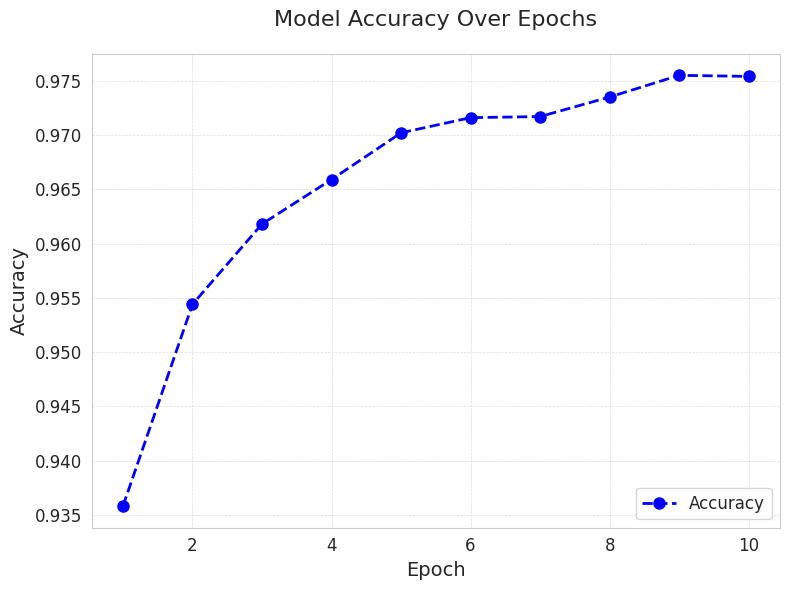

In [17]:
def visualize_accuracy(
    accuracy_list: List[float],
    save_plot: bool = False,
    filename: str = "accuracy_over_epochs.png",
) -> None:
    """
    Visualize the accuracy of a model over training epochs with enhanced aesthetics.

    Args:
        accuracy_list (List[float]): List of accuracy values for each epoch.
        save_plot (bool): If True, saves the plot as an image file. Default is False.
        filename (str): Name of the file to save the plot. Default is "accuracy_over_epochs.png".

    Returns:
        None: Displays a plot of accuracy over epochs.
    """
    if not accuracy_list:
        raise ValueError("The accuracy list is empty.")

    num_of_epochs = len(accuracy_list)

    sns.set_style("whitegrid")
    sns.set_palette("deep")

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot accuracy over epochs
    ax.plot(
        range(1, num_of_epochs + 1),  # Epochs
        accuracy_list,                # Accuracy values
        linestyle="--",               # Dashed line style
        marker="o",                   # Circle markers
        markersize=8,                 # Marker size
        linewidth=2,                  # Line width
        color="b",                    # Line color
        label="Accuracy"              # Label for legend
    )

    ax.set_xlabel("Epoch", fontsize=14)
    ax.set_ylabel("Accuracy", fontsize=14)
    ax.set_title("Model Accuracy Over Epochs", fontsize=16, pad=20)

    ax.tick_params(axis="both", which="major", labelsize=12)

    ax.grid(visible=True, which="major", linestyle="--", linewidth=0.5, alpha=0.7)

    ax.legend(fontsize=12, loc="lower right")

    plt.tight_layout()

    if save_plot:
        plt.savefig(filename, dpi=800, bbox_inches="tight")

    plt.show()


visualize_accuracy(accuracy_list=accuracy_list, save_plot=True)

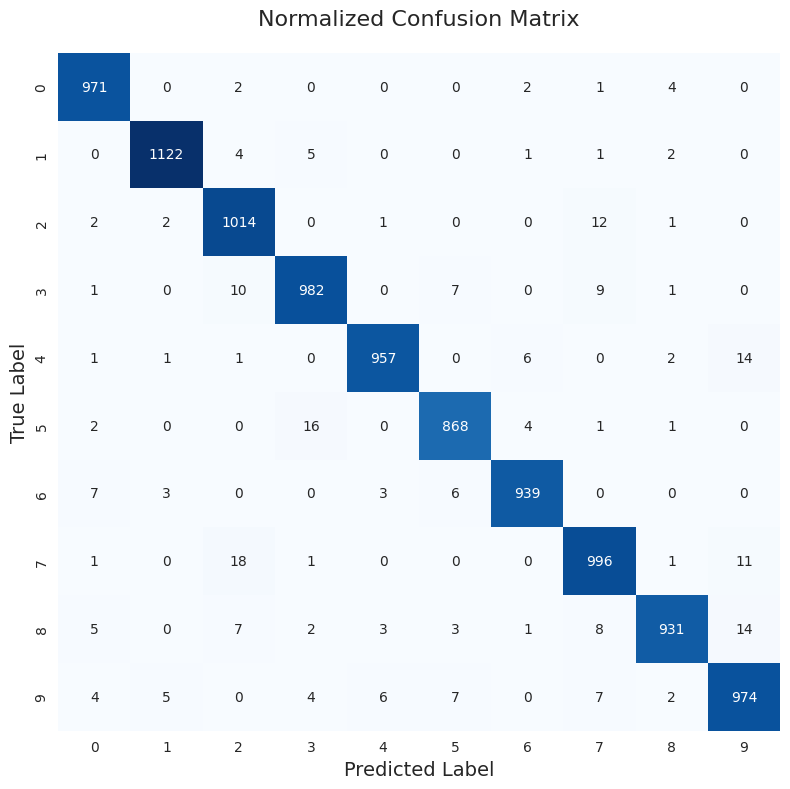

In [18]:
from typing import Optional

def plot_confusion_matrix(
    cm: np.ndarray,
    class_names: List[str],
    normalize: bool = False,
    title: Optional[str] = "Confusion Matrix",
    save_plot: bool = False,
    filename: str = "confusion_matrix.png",
) -> None:
    """
    Plot the confusion matrix using Seaborn's heatmap.

    Args:
        cm (np.ndarray): Confusion matrix.
        class_names (List[str]): Names of the classes.
        normalize (bool): If True, normalize the confusion matrix by row. Default is False.
        title (Optional[str]): Title of the plot. Default is "Confusion Matrix".
        save_plot (bool): If True, saves the plot as an image file. Default is False.
        filename (str): Name of the file to save the plot. Default is "confusion_matrix.png".

    Returns:
        None: Displays a plot of the confusion matrix.
    """
    if not isinstance(cm, np.ndarray) or cm.ndim != 2:
        raise ValueError("Confusion matrix must be a 2D numpy array.")
    if len(class_names) != cm.shape[0]:
        raise ValueError("Length of class_names must match the dimensions of the confusion matrix.")

    sns.set_style("whitegrid")
    sns.set_palette("deep")

    # Normalize the confusion matrix if requested
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot heatmap
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False,
    )

    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)
    ax.set_title(title, fontsize=16, pad=20)

    plt.tight_layout()

    # Save the plot if requested
    if save_plot:
        plt.savefig(filename, dpi=800, bbox_inches="tight")

    plt.show()


class_names = [str(i) for i in range(10)]
plot_confusion_matrix(
    cm=cm,
    class_names=class_names,
    normalize=False,
    title="Normalized Confusion Matrix",
    save_plot=True,
)

# Evaluating the model Performance. Displaying instances.

In [19]:
import random as rn
import matplotlib.pyplot as plt
import math

model.eval()


def test_it(num_of_images: int) -> None:
    """Test the model on a random set of images and display predictions in a grid."""
    indices = [rn.randint(0, len(test_data) - 1) for _ in range(num_of_images)]
    
    images_per_row = 5  # Number of images in each row
    num_rows = math.ceil(num_of_images / images_per_row)  # Calculate required rows

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2))

    # Flatten axes array if there's more than one row
    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, idx in enumerate(indices):
        data, target = test_data[idx]
        data = data.unsqueeze(0).to(device)

        output = model(data)
        prediction = output.argmax(dim=1).item()

        print(f'Image {idx}: Prediction={prediction}, Actual={target}')

        image = data.squeeze().cpu().numpy()

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Pred: {prediction}', fontsize=8)
        axes[i].axis('off')

    # Hide any unused subplots (if total images aren't exactly a multiple of images_per_row)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Image 1586: Prediction=3, Actual=3
Image 5509: Prediction=4, Actual=4
Image 3338: Prediction=9, Actual=9
Image 7037: Prediction=0, Actual=0
Image 6087: Prediction=5, Actual=5
Image 9072: Prediction=2, Actual=2
Image 6208: Prediction=7, Actual=7
Image 9282: Prediction=1, Actual=1
Image 4859: Prediction=1, Actual=1
Image 4757: Prediction=0, Actual=0
Image 9773: Prediction=7, Actual=7
Image 6169: Prediction=4, Actual=4
Image 6634: Prediction=1, Actual=1
Image 8754: Prediction=4, Actual=4
Image 2861: Prediction=2, Actual=2
Image 9462: Prediction=8, Actual=8
Image 5048: Prediction=7, Actual=7
Image 2610: Prediction=2, Actual=2
Image 643: Prediction=2, Actual=2
Image 9900: Prediction=8, Actual=8


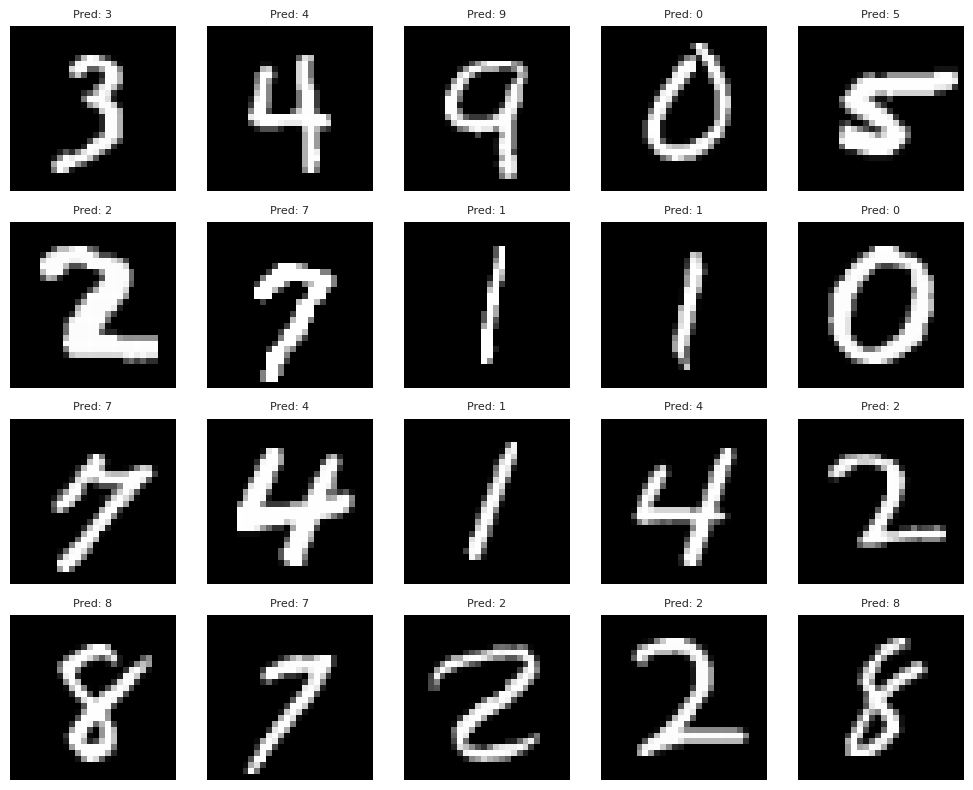

In [20]:
test_it(20)

# GUI

## Importing Libraries

In [21]:
import tkinter as tk
from tkinter import Canvas, Button
from PIL import Image, ImageDraw, ImageGrab

## GUI Application Code

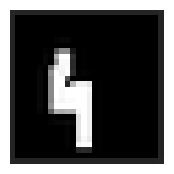

In [22]:
class MNISTDigitRecognizer:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.root = tk.Tk()
        self.root.title("Digit Recognizer (PyTorch)")
        self.setup_ui()

    def setup_ui(self):
        """Set up the Tkinter UI."""
        # Canvas for drawing
        self.canvas_width, self.canvas_height = 28, 28
        self.canvas = Canvas(self.root, width=self.canvas_width, height=self.canvas_height, bg="white")
        self.canvas.pack()

        # Blank image to store the drawing
        self.image = Image.new("L", (self.canvas_width, self.canvas_height), 255)
        self.draw_obj = ImageDraw.Draw(self.image)

        # Buttons
        predict_button = Button(self.root, text="Predict", command=self.recognize_digit)
        predict_button.pack(side=tk.LEFT)

        clear_button = Button(self.root, text="Clear", command=self.clear_canvas)
        clear_button.pack(side=tk.RIGHT)

        # Label for prediction result
        self.result_label = tk.Label(self.root, text="Predicted Digit: ", font=("Arial", 16))
        self.result_label.pack()

        # Bind drawing function
        self.canvas.bind("<B1-Motion>", self.draw)

    def preprocess_image(self, image):
        """Preprocess the drawn image for prediction."""
        image = image.convert("L")
        image = image.resize((28, 28), Image.Resampling.LANCZOS)
        image = np.array(image, dtype=np.float32) / 255.0
        image = 1 - image
        image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        return image_tensor

    def recognize_digit(self):
        """Predict the digit drawn on the canvas."""
        x = self.root.winfo_rootx() + self.canvas.winfo_x()
        y = self.root.winfo_rooty() + self.canvas.winfo_y()
        x1 = x + self.canvas.winfo_width()
        y1 = y + self.canvas.winfo_height()
        img = ImageGrab.grab((x, y, x1, y1))

        img_processed = self.preprocess_image(img)

        with torch.no_grad():
            output = self.model(img_processed)
            _, predicted = torch.max(output, 1)
        digit = predicted.item()

        self.result_label.config(text=f"Recognized Digit: {digit}")

        plt.figure(figsize=(2, 2))
        plt.imshow(img_processed.squeeze(), cmap="gray")
        plt.axis("off")
        plt.show()

    def clear_canvas(self):
        """Clear the canvas and reset the image."""
        self.canvas.delete("all")
        self.draw_obj.rectangle([0, 0, 28, 28], fill="white")
        self.result_label.config(text="Recognized Digit: ")

    def draw(self, event):
        """Draw on the canvas and update the image."""
        x, y = event.x, event.y
        r = 0.6  # Stroke thickness
        self.canvas.create_oval(x - r, y - r, x + r, y + r, fill="black", outline="black")
        self.draw_obj.ellipse([x - r, y - r, x + r, y + r], fill=0)

    def run(self):
        """Run the Tkinter main loop."""
        self.root.mainloop()



app = MNISTDigitRecognizer(model)
app.run()

# Resources

1. https://www.youtube.com/watch?v=vBlO87ZAiiw. NeuralNine. PyTorch Project: Handwritten Digit Recognition.
2. https://github.com/billy-enrizky/Pytorch-Handwritten-Digit-Recognition.
3. https://matplotlib.org/stable/tutorials/images.html
4. https://realpython.com/python-gui-tkinter/#building-your-first-python-gui-application-with-tkinter
5. https://www.kaggle.com/code/ahmedelmaamounamin/handwritten-digit-recognition-with-gui/code#Handwritten-Digit-Recognition-with-GUI
6. https://www.tutorialspoint.com/matplotlib/matplotlib_object_oriented_interface.htm
7. https://seaborn.pydata.org/generated/seaborn.heatmap.html